#Ejercicio 2

- Visualice el kernel rbf para diferentes condiciones de ruido sintonizando los hiperparámetros del modelo utilizando gridsearch. *Ayuda*: modifique la varianza del ruido.

- Realice una descomposición en valores propios de la matriz kernel para cada una de las condiciones de ruido del punto anterior, qué puede discutir sobre el espectro de la matríz y su influencia en el modelo predictivo de kernel ridge?. Cuál es la relación entre el espectro visualizado y el hiperparámetro de regularización o penalidad encontrado por gridsearch en cada caso?. *Ayuda*: utilizando numpy encuentre la descomposición de valores y vectores propios de $\mathbf{K}$ y $\mathbf{K}+\alpha\mathbf{I}$, según los valores de $\gamma$ y $\alpha$ encontrados por GridsearchCV ante cada condición de ruido evaluada.




In [7]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
import matplotlib.pyplot as plt

------ Analysing var = 0.01 -----
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best gamma: 0.1, Best alpha: 0.1
------ Analysing var = 0.1 -----
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best gamma: 0.1, Best alpha: 1
------ Analysing var = 0.2 -----
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best gamma: 0.1, Best alpha: 1
------ Analysing var = 0.5 -----
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best gamma: 0.1, Best alpha: 10
------ Analysing var = 1 -----
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best gamma: 0.1, Best alpha: 10
------ Analysing var = 5 -----
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best gamma: 0.1, Best alpha: 10
------ Analysing var = 10 -----
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best gamma: 1, Best alpha: 100


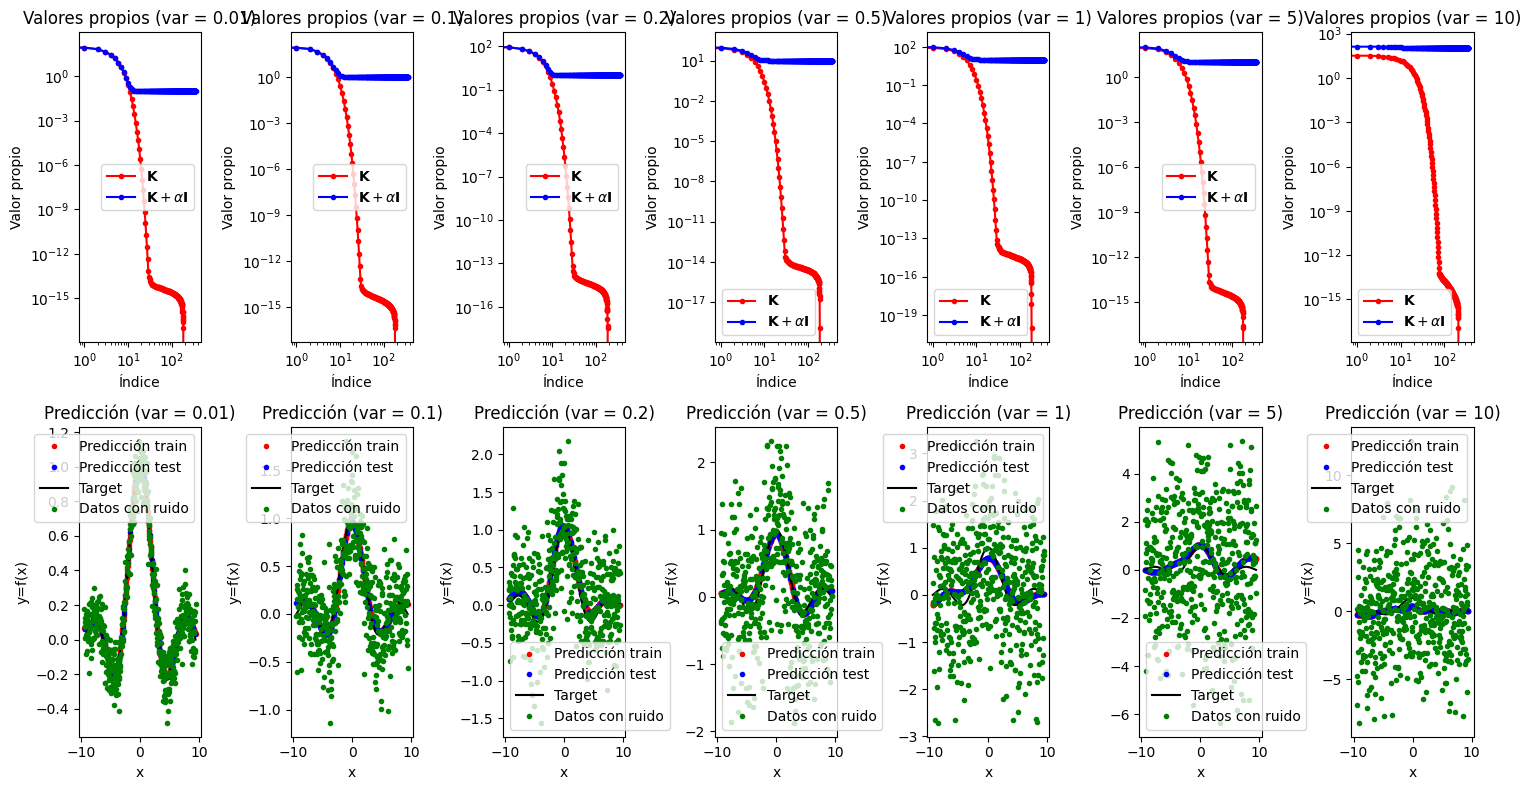

In [8]:
var_v = [0.01, 0.1, 0.2, 0.5, 1, 5, 10]
N = 500
X = np.linspace(-3*np.pi, 3*np.pi, N)
y = np.sinc(X/np.pi)

def noise_grid_search(y, N, X):

    fig, axs = plt.subplots(2, len(var_v), figsize=(15, 8))

    for idx, var in enumerate(var_v):
        
        noise = np.sqrt(var) * np.random.randn(N)
        yn = y + noise 

        
        ydata = yn.reshape(-1, 1)
        Xdata = X.reshape(-1, 1)

        
        X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.3)

        
        steps = [('reg', KernelRidge(kernel='rbf'))]
        parameters = {
            'reg__alpha': [0, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000],
            'reg__gamma': [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000],
        }

        pipeline = Pipeline(steps=steps)

        print(f'------ Analysing var = {var} -----')

        grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, cv=10,
                                   scoring='neg_mean_absolute_error', verbose=10, refit=True)
        grid_search.fit(X_train, y_train)

        
        best_model = grid_search.best_estimator_
        
        best_params = grid_search.best_params_
        
        alpha = best_params['reg__alpha']
        gamma = best_params['reg__gamma']

        print(f'Best gamma: {gamma}, Best alpha: {alpha}')

    
        K = rbf_kernel(X_train, X_train, gamma=gamma)

        
        eigvals_K, eigvecs_K = np.linalg.eigh(K)

        
        K_alpha = K + alpha * np.eye(K.shape[0])
        eigvals_K_alpha, eigvecs_K_alpha = np.linalg.eigh(K_alpha)

        
        axs[0, idx].loglog(eigvals_K[::-1], 'r.-', label=r'$\mathbf{K}$')
        axs[0, idx].loglog(eigvals_K_alpha[::-1], 'b.-', label=r'$\mathbf{K} + \alpha \mathbf{I}$')
        axs[0, idx].set_title(f'Valores propios (var = {var})')
        axs[0, idx].set_xlabel('Índice')
        axs[0, idx].set_ylabel('Valor propio')
        axs[0, idx].legend()

        
        y_test_e = best_model.predict(X_test)
        y_train_e = best_model.predict(X_train)
        
        axs[1, idx].plot(X_train, y_train_e, 'r.', label='Predicción train')
        axs[1, idx].plot(X_test, y_test_e, 'b.', label='Predicción test')
        axs[1, idx].plot(X, y, 'k', label='Target')
        axs[1, idx].plot(Xdata, ydata, 'g.', label='Datos con ruido')
        axs[1, idx].set_xlabel('x')
        axs[1, idx].set_ylabel('y=f(x)')
        axs[1, idx].set_title(f'Predicción (var = {var})')
        axs[1, idx].legend()

    plt.tight_layout()
    plt.show()


noise_grid_search(y, N, X)


Se puede apreciar que el ruido hace que la matriz de valores $$K$$ se va alejando de la matriz $$K + \alpha I$$. Hasta que llega un punto en el que la matriz $$K + \alpha I$$ no llega a parecerse a la matriz $$K$$, por lo que al saber que la matriz que es la verosimilitud entre los datos, podemos concluir que al haber más ruido le es más dificil al kernek encontrar patrones entre los datos, hasta cierto punto que ya la señal original se pierde.